In [1]:
from typing import Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.cascading_trade_network import AGDP
from src.reading import expected_gdp
from src.plotting import plot_metric_map

In [2]:
def get_params(
    Model: Callable, upper_q=0.75, lower_q=0.25, tol=1e-3, timespan=2
) -> list[float]:
    """
    Find optimal model parameters for the Great Recession scenario.

    Arguments:
        Model (Callable): the model object (e.g., cascading_trade_network.AGDP).
        uppper_q, lower_q (float): the data quantiles to which fit the model.
        tol (float): the precision of the optimsation.
        timespan (int): how many years to use for the expected GDP estimation.

    Returns:
        list of found parameter values for the lower quantile, median and upper quantile.
    """
    # 2007-2009 recession fit
    # SETUP
    G = Model(
        trade_file="../data/trade/imf_cif_2007_import.xlsx",
        gdp_file="../data/gdp/gdp_1960_2023_in_2015USD.csv",
        gdp_years=[2007],
        country_list_file="../data/country_list.csv",
        inflation_file="../data/inflation.csv",
    )
    gdps = expected_gdp(
        pd.read_csv("../data/country_list.csv"),
        extrapolate_from=list(range(2007 - timespan + 1, 2007 + 1)),
        extrapolate_to=2009,
        gdp_file="../data/gdp/gdp_1960_2023_in_2015USD.csv",
        inflation_file="../data/inflation.csv",
    )
    # make sure country lists are identical
    gdps = {n: gdps[n] for n in gdps if n in G}
    G.remove_nodes_from([n for n in G if n not in gdps])
    assert len(G) == len(gdps)

    # INITIAL CONDITION
    USA_loss = 1 - gdps["USA"][1] / gdps["USA"][0]

    # Y_TRUE (compute (log-)losses)
    loss = dict(
        zip(
            [n for n in gdps if gdps[n][0] > gdps[n][1]],
            [gdps[n][0] - gdps[n][1] for n in gdps if gdps[n][0] > gdps[n][1]],
        )
    )
    log_loss = dict(zip(loss.keys(), np.log(list(loss.values()))))

    # FIND MINIMA (optimal control parameter values)
    minima = G.fit(log_loss, [lower_q, 0.5, upper_q], {"USA": USA_loss}, tol, log=True)
    return [a[0] for _, a in minima.items()]

In [3]:
# specify hyper-parameters
timespan=4
model=AGDP
res = []
dq = 0.5
# decide on initial losses (the trigger for the cascade)
# here we use an example of Inida-Pakistan nuclear conflict
# (industrial loss as fraction of GDP + fatalities x gdp per capita) / GDP
# industrial loss % and # of fatalities are estimates of Blouin et al.
india_loss = (3.55e12 * 1.5 / 100 * 25.0 / 100 + 33e6 * 2484.8) / 3.55e12
pak_loss = (
    338.37e9 * 8 / 100 * 20.8 / 100 + 24e6 * 338.37e9 / 241_499_431
) / 338.37e9
print("India init loss [%]:", india_loss * 100)
print("Pakistan init loss [%]:", pak_loss * 100)
# MODEL SETUP
G = model(
    trade_file="../data/trade/imf_cif_2023_import.xlsx",
    gdp_file="../data/gdp/gdp_1960_2023_in_2015USD.csv",
    gdp_years=[2023],
    country_list_file="../data/country_list.csv",
    inflation_file="../data/inflation.csv",
)
# parameter values for the model are found on a seperate dataset (Great Recession in this case)
params = get_params(model, 1 - (1 - dq) / 2, (1 - dq) / 2, timespan=timespan)

India init loss [%]: 2.6848140845070425
Pakistan init loss [%]: 11.601911613547445
reading.load_data() WARNING:
These countries shan't be included as they are not present in all data sets:
{'VEN', 'TWN', 'YEM', 'SSD', 'SYR', 'ERI', 'LBN', 'PRK', 'BTN'}
reading.load_data() WARNING:
These countries shan't be included as they are not present in all data sets:
{'SSD', 'VEN', 'PRK', 'TWN', 'DJI'}
reading.extrapolate_gdp() WARNING:
SSD doesn't have sufficient data to extrapolate GDP; skipping.


In [4]:
# we can make predictions now
# lower and upper estimates for the cumulative global loss
min_sum = sum(G.predict(list(G.nodes()), params[0], {"IND": india_loss, "PAK": pak_loss}).values())
max_sum = sum(G.predict(list(G.nodes()), params[2], {"IND": india_loss, "PAK": pak_loss}).values())
# median prediction: a dictionary country -> loss
pred = G.predict(list(G.nodes()), params[1], {"IND": india_loss, "PAK": pak_loss})

In [5]:
print(f"Expected total global losses: [{min_sum}, {max_sum}] (in 2023 USD)")

Expected total global losses: [431872539986.0641, 2706863212170.113] (in 2023 USD)


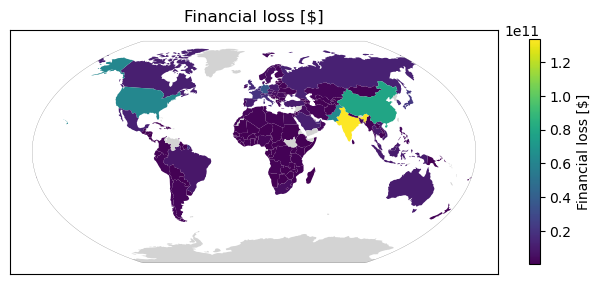

In [6]:
# we can plot a map showing losses for each country
# here we use the median prediction
_, ax = plt.subplots(tight_layout=True)
plot_metric_map(ax, pred, "Financial loss [$]", world_map_file="../data/map/ne_110m_admin_0_countries.shp", shrink=0.5)
plt.show()